# Ensemble Training Notebook (from `train_ensemble.py`)

- **원본 파일**: `train_ensemble.py`
- **설명**: CLI로 돌리던 학습 스크립트를 노트북 셀 단위로 옮긴 버전.
- **주의**: 기능 코드(함수 정의, 로직, 인자 이름)는 원본과 동일하게 유지함.
- **제출자**: _(여기에 이름/학번/과제명 쓰기)_

아래 셀을 위에서부터 순서대로 실행하면 스크립트와 동일하게:
1. 데이터 로드 및 시간 분할
2. 그룹 누수 제거 (옵션)
3. RF + (옵션) LGBM 학습
4. 앙상블 + 평가 + 그림 저장
5. 모델/메타 저장
까지 수행함.

In [1]:
import argparse, json, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import joblib

from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

In [2]:
# ----------------------------
# 데이터 로드 (id-cols 드랍)
# ----------------------------
def load_xy(path: str, ts_col: str, id_cols=None):
    id_cols = id_cols or []
    df = pd.read_csv(path, parse_dates=[ts_col]).sort_values(ts_col)
    if "passorfail" not in df.columns:
        raise ValueError("`passorfail` 라벨 컬럼이 필요합니다.")
    drop_cols = ["passorfail", ts_col] + id_cols
    X = df.drop(columns=drop_cols, errors="ignore")
    # 숫자형만 사용 + inf 처리
    num_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]
    X = X[num_cols].replace([np.inf, -np.inf], np.nan)
    # 전부 NA인 컬럼 제거
    all_na = X.columns[X.isna().all()].tolist()
    if all_na:
        X = X.drop(columns=all_na)
    y = df["passorfail"].astype(int)
    # ts + id들은 따로 반환 (검증 누수 체크용)
    info = df[[ts_col] + [c for c in id_cols if c in df.columns]].reset_index(drop=True)
    return info, X.reset_index(drop=True), y.reset_index(drop=True)

In [3]:
# ----------------------------
# 시간 분할 (양성 보장)
# ----------------------------
def temporal_split_posaware(times: pd.Series, X: pd.DataFrame, y: pd.Series, base_ratio=0.7, min_pos_train=1, min_pos_valid=1):
    n = len(y)
    idx = int(n * base_ratio)
    def ok(i):
        return (y.iloc[:i].sum() >= min_pos_train) and (y.iloc[i:].sum() >= min_pos_valid)
    if ok(idx):
        return (times.iloc[:idx], times.iloc[idx:], X.iloc[:idx], X.iloc[idx:], y.iloc[:idx], y.iloc[idx:])
    step = max(1, int(n * 0.005))
    for i in range(idx, n-1, step):
        if ok(i): return (times.iloc[:i], times.iloc[i:], X.iloc[:i], X.iloc[i:], y.iloc[:i], y.iloc[i:])
    for i in range(idx, 1, -step):
        if ok(i): return (times.iloc[:i], times.iloc[i:], X.iloc[:i], X.iloc[i:], y.iloc[:i], y.iloc[i:])
    pos_idx = np.where(y.values == 1)[0]
    i = int(pos_idx[-1]) if len(pos_idx) > 0 else idx
    i = min(max(1, i), n-1)
    return (times.iloc[:i], times.iloc[i:], X.iloc[:i], X.iloc[i:], y.iloc[:i], y.iloc[i:])

# ----------------------------
# 그룹 누수 차단: train 그룹과 겹치는 검증 행 제거
# ----------------------------
def remove_val_group_overlap(info_df, id_cols, tr_idx, va_idx):
    if not id_cols:
        return va_idx, {"applied": False, "checked_cols": [], "removed": 0, "va_size_before": int(len(va_idx)), "va_size_after": int(len(va_idx))}
    va_mask = pd.Series(True, index=va_idx)
    summary = {"applied": True, "checked_cols": [], "removed": 0, "va_size_before": int(len(va_idx))}
    for g in id_cols:
        if g not in info_df.columns:
            continue
        summary["checked_cols"].append(g)
        tr_groups = set(info_df.loc[tr_idx, g].dropna())
        hit = info_df.loc[va_idx, g].isin(tr_groups)
        # 누적 마스크: 하나라도 겹치면 제거
        va_mask = va_mask & (~hit)
    kept_va_idx = va_idx[va_mask.values]
    summary["removed"] = int(len(va_idx) - len(kept_va_idx))
    summary["va_size_after"] = int(len(kept_va_idx))
    # 진짜로 많이 날아가면 경고
    if summary["va_size_before"] > 0 and summary["va_size_after"] / summary["va_size_before"] < 0.5:
        warnings.warn(f"[leak-guard] Validation cut by >50% after group filtering ({summary['va_size_before']} -> {summary['va_size_after']}). Check your split or id-cols.")
    return kept_va_idx, summary

In [4]:
# ----------------------------
# 모델 (full 버전 성향 유지)
# ----------------------------
def fit_rf_calibrated_like_full(X_tr, y_tr, random_state=42):
    rf = RandomForestClassifier(
        n_estimators=1200,
        max_depth=None,
        max_features="sqrt",
        min_samples_leaf=3,
        class_weight="balanced",
        bootstrap=True,
        n_jobs=-1,
        random_state=random_state,
    )
    imp_pipe = make_pipeline(SimpleImputer(strategy="median"))
    X_tr_imp = imp_pipe.fit_transform(X_tr)
    rf_cal = CalibratedClassifierCV(rf, method="sigmoid", cv=3)
    rf_cal.fit(X_tr_imp, y_tr)
    return rf_cal, imp_pipe

def fit_lgbm_like_full(X_tr, y_tr, X_va, y_va, random_state=42):
    try:
        import lightgbm as lgb
    except Exception:
        return None, None
    pos = max(1, int((y_tr == 1).sum()))
    neg = max(1, int((y_tr == 0).sum()))
    ratio = neg / pos
    clf = lgb.LGBMClassifier(
        n_estimators=3000,
        learning_rate=0.02,
        num_leaves=127,
        max_depth=-1,
        min_data_in_leaf=100,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=1,
        lambda_l1=1.0,
        lambda_l2=2.0,
        scale_pos_weight=ratio,
        n_jobs=-1,
        random_state=random_state,
    )
    imp = SimpleImputer(strategy="median")
    X_tr_imp = imp.fit_transform(X_tr)
    X_va_imp = imp.transform(X_va)
    clf.fit(
        X_tr_imp, y_tr,
        eval_set=[(X_va_imp, y_va)],
        eval_metric="average_precision",
        callbacks=[lgb.early_stopping(200), lgb.log_evaluation(50)],
    )
    return clf, imp

In [5]:
# ----------------------------
# 임계값 정책
# ----------------------------
def best_thr_f1(y, s):
    p, r, t = precision_recall_curve(y, s)
    f1 = 2 * p * r / (p + r + 1e-12)
    if len(t) == 0:
        return 0.5, {"precision": float(p.max() if len(p) else 0.0),
                     "recall": float(r[np.argmax(p)] if len(r) else 0.0),
                     "f1": float(f1.max() if len(f1) else 0.0)}
    bi = int(np.nanargmax(f1[:-1]))
    thr = float(t[bi])
    return thr, {"precision": float(p[bi]), "recall": float(r[bi]), "f1": float(f1[bi])}

# ----------------------------
# 시각화
# ----------------------------
def plot_pr_curve(y_true, scores, ap, out_path):
    import matplotlib.pyplot as plt
    p, r, _ = precision_recall_curve(y_true, scores)
    plt.figure(figsize=(6,5), dpi=140)
    plt.plot(r, p, label=f"Ensemble (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left"); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig(out_path); plt.close()

def plot_confusion_matrix(cm_dict, title, out_path):
    import matplotlib.pyplot as plt
    import numpy as np
    cm = np.array([[cm_dict["tn"], cm_dict["fp"]],
                   [cm_dict["fn"], cm_dict["tp"]]], dtype=int)
    plt.figure(figsize=(5.2,4.6), dpi=140)
    plt.imshow(cm, interpolation="nearest")
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.xticks([0,1], ["Negative","Positive"]); plt.yticks([0,1], ["Negative","Positive"])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, f"{v}", ha="center", va="center")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.savefig(out_path); plt.close()

In [6]:
# ----------------------------
# 메인
# ----------------------------
def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--input", default="train_features_60m.csv")
    ap.add_argument("--ts-col", default="datetime")
    ap.add_argument("--id-cols", nargs="*", default=[])  # 예: --id-cols lot_id batch_id
    ap.add_argument("--w-rf", type=float, default=0.7)
    ap.add_argument("--w-lgb", type=float, default=0.3)
    ap.add_argument("--enforce-group-uniqueness", action="store_true",
                    help="검증셋에서 train과 겹치는 그룹(id-cols)을 제거")
    
    args = ap.parse_args()

    models_dir = Path("models"); models_dir.mkdir(parents=True, exist_ok=True)
    evals_dir  = Path("evals");  evals_dir.mkdir(parents=True, exist_ok=True)

    # 1) 데이터 & 분할
    info, X, y = load_xy(args.input, args.ts_col, id_cols=args.id_cols)
    t_tr, t_va, X_tr, X_va, y_tr, y_va = temporal_split_posaware(info[args.ts_col], X, y)

    # 2) 그룹 누수 제거(옵션)
    leak_report = {"applied": False}
    if args.enforce_group_uniqueness and args.id_cols:
        tr_idx = t_tr.index
        va_idx = t_va.index
        kept_va_idx, leak_report = remove_val_group_overlap(info, args.id_cols, tr_idx, va_idx)
        # 인덱스 재정렬
        X_va = X_va.loc[kept_va_idx]
        y_va = y_va.loc[kept_va_idx]
        t_va = t_va.loc[kept_va_idx]

    # 3) 모델 학습 (full 설정 유지)
    rf_cal, imp_rf = fit_rf_calibrated_like_full(X_tr, y_tr)
    lgbm, imp_lgb = fit_lgbm_like_full(X_tr, y_tr, X_va, y_va)

    # 4) 예측 & 앙상블
    s_rf = rf_cal.predict_proba(imp_rf.transform(X_va))[:, 1]
    s_lgb = np.zeros_like(s_rf)
    if lgbm is not None:
        s_lgb = lgbm.predict_proba(imp_lgb.transform(X_va))[:, 1]
    s_ens = args.w_rf * s_rf + args.w_lgb * s_lgb

    # 5) 지표/임계값
    ap_ens = float(average_precision_score(y_va, s_ens))
    thr, m = best_thr_f1(y_va, s_ens)

    def prf1_at(th):
        y_hat = (s_ens >= th).astype(int)
        tp = int(((y_hat == 1) & (y_va == 1)).sum())
        fp = int(((y_hat == 1) & (y_va == 0)).sum())
        fn = int(((y_hat == 0) & (y_va == 1)).sum())
        tn = int(((y_hat == 0) & (y_va == 0)).sum())
        prec = tp / (tp + fp + 1e-12)
        rec = tp / (tp + fn + 1e-12)
        f1  = 2 * prec * rec / (prec + rec + 1e-12)
        return {"threshold": float(th), "precision": float(prec), "recall": float(rec),
                "f1": float(f1), "tp": tp, "fp": fp, "fn": fn, "tn": tn}

    grid = np.arange(max(0.0, thr - 0.05), min(1.0, thr + 0.05) + 1e-9, 0.01)
    sensitivity = [prf1_at(float(t)) for t in np.round(grid, 4)]

    p, r, t = precision_recall_curve(y_va, s_ens)
    f1 = 2 * p * r / (p + r + 1e-12)
    idxs = [i for i in range(len(f1)-1) if r[i] >= 0.98]
    if len(idxs) == 0:
        thr_constr = float(thr)
        m_constr = prf1_at(thr_constr)
        m_constr["note"] = "no_threshold_meets_recall>=0.98; fallback=best_f1"
    else:
        bi2 = int(np.nanargmax([f1[i] for i in idxs]))
        i2 = idxs[bi2]
        thr_constr = float(t[i2]) if i2 < len(t) else float(thr)
        m_constr = prf1_at(thr_constr)

    def cm_counts(th):
        y_pred = (s_ens >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_va, y_pred, labels=[0,1]).ravel()
        return {"tp": int(tp), "fp": int(fp), "fn": int(fn), "tn": int(tn)}
    cm_best = cm_counts(thr)
    cm_constr = cm_counts(thr_constr)

    # 6) eval 저장
    eval_summary = {
        "average_precision": ap_ens,
        "best_threshold_f1": float(thr),
        "precision": m["precision"], "recall": m["recall"], "f1": m["f1"],
        "weights": {"rf": float(args.w_rf), "lgb": float(args.w_lgb)},
        "lightgbm_used": bool(lgbm is not None),
        "sensitivity_window": sensitivity,
        "constrained_threshold_R>=0.98": {
            "threshold": float(thr_constr),
            "precision": float(m_constr["precision"]),
            "recall": float(m_constr["recall"]),
            "f1": float(m_constr["f1"]),
            "tp": int(m_constr["tp"]), "fp": int(m_constr["fp"]),
            "fn": int(m_constr["fn"]), "tn": int(m_constr["tn"]),
            "note": m_constr.get("note", "")
        },
        "confusion_matrix": {"at_best_f1": cm_best, "at_constrained": cm_constr},
        "leak_checks": leak_report
    }
    Path("evals/eval_summary.json").write_text(json.dumps(eval_summary, ensure_ascii=False, indent=2), encoding="utf-8")

    # 7) 그림 저장
    plot_pr_curve(y_va, s_ens, ap_ens, Path("evals/pr_curve.png"))
    plot_confusion_matrix(cm_best, "Confusion Matrix @ Best F1", Path("evals/confusion_matrix_best.png"))
    plot_confusion_matrix(cm_constr, "Confusion Matrix @ Recall≥0.98", Path("evals/confusion_matrix_constrained.png"))

    # 8) 모델/메타 저장
    joblib.dump(rf_cal, Path("models/model_RF_calibrated.pkl"))
    if lgbm is not None:
        joblib.dump(lgbm, Path("models/model_LightGBM.pkl"))

    meta_path = Path("models/model_meta.json")
    meta = json.loads(meta_path.read_text(encoding="utf-8")) if meta_path.exists() else {}
    meta["Ensemble"] = {
        "type": "soft_voting",
        "weights": {"rf": float(args.w_rf), "lgb": float(args.w_lgb)},
        "components": {
            "rf_calibrated_pkl": "models/model_RF_calibrated.pkl",
            "lgbm_pkl": "models/model_LightGBM.pkl" if lgbm is not None else None,
        },
        "threshold": float(thr),
    }
    meta_path.write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")

    # 9) 콘솔 요약
    print("\n[SUMMARY]")
    print(f"AP(Ensemble)={ap_ens:.4f}")
    print(f"BestThr(F1-max)={thr:.4f}  P={m['precision']:.4f} R={m['recall']:.4f} F1={m['f1']:.4f}")
    if leak_report.get("applied", False):
        print(f"Leak guard: checked {leak_report.get('checked_cols')} | "
              f"removed {leak_report.get('removed')} overlapped val rows "
              f"({leak_report.get('va_size_after')}/{leak_report.get('va_size_before')})")
    print("Saved:")
    print("  - models/: model_RF_calibrated.pkl, (opt) model_LightGBM.pkl, model_meta.json")
    print("  - evals/: eval_summary.json, pr_curve.png, confusion_matrix_best.png, confusion_matrix_constrained.png")

if __name__ == "__main__":
    # 노트북에서는 이 부분이 바로 실행되지 않도록 둔다.
    # 아래 셀에서 main()을 직접 호출해서 돌릴 것.
    pass

In [10]:
# ▶️ 실행 셀
# 노트북에서 직접 돌릴 때는 아래처럼 바로 main()을 호출하면 된다.
# 필요하면 아래 주석처럼 인자 흉내를 내도 된다.

import sys
sys.argv = [
    "train_ensemble.py",
    "--input", "dataset/train_features_60m.csv",
    "--ts-col", "datetime",
    "--id-cols", "lot_id", "batch_id",
    "--w-rf", "0.7",
    "--w-lgb", "0.3",
    "--enforce-group-uniqueness"
]

main()

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. 

cwd: /home/kampuser


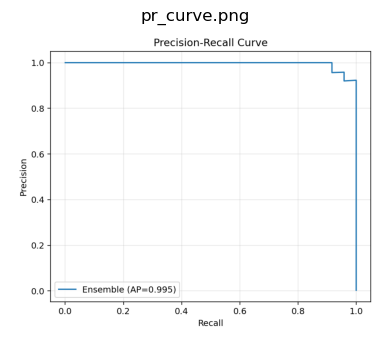

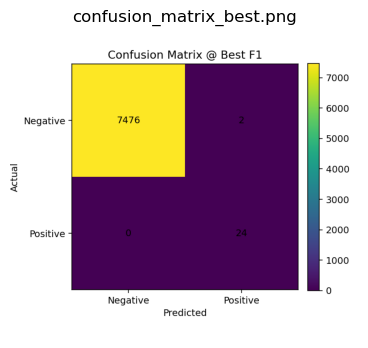

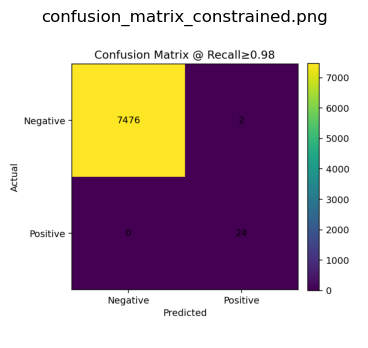

In [11]:
# 📊 evals에 저장된 결과 그래프들 한 번에 보기
import os
from PIL import Image
import matplotlib.pyplot as plt

# 1) 현재 작업 디렉토리 확인
print("cwd:", os.getcwd())

# 2) evals 경로 설정
#   - 노트북이랑 evals가 같은 폴더면 이대로 쓰면 되고
#   - 한 단계 위에 있으면  img_dir = "../evals" 로 바꿔
img_dir = "evals"

plots = [
    "pr_curve.png",
    "confusion_matrix_best.png",
    "confusion_matrix_constrained.png",
    # 혹시 이 스크립트가 추가로 저장하는 게 있으면 아래에 더 적어
    # "roc_curve.png",
]

if not os.path.exists(img_dir):
    print(f"[WARN] '{img_dir}' 폴더가 현재 위치에 없음. 경로 한 번 확인해라.")
else:
    for name in plots:
        path = os.path.join(img_dir, name)
        if os.path.exists(path):
            img = Image.open(path)
            plt.figure(figsize=(5, 4))
            plt.imshow(img)
            plt.axis("off")
            plt.title(name)
            plt.show()
        else:
            print(f"[WARN] {path} 없어서 스킵함")
